In [1]:
#@title Setup (may take a few minutes)
import os


# !pip install accelerate
# !pip install diffusers
# !pip install transformers
# !pip install kornia==0.6.11
# !pip install pyrallis==0.3.1



import torch

import os
from pathlib import Path
import torch.utils.checkpoint
import itertools
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
import prompt_dataset
import utils
import cv2
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import shutil
from InstaFlow.code.pipeline_rf import RectifiedFlowPipeline
import time
from transformers import CLIPProcessor
import numpy as np
import torchvision.transforms.functional as TF
from transformers import CLIPModel
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(



# Hyperparameters

In [2]:
classifier: str = 'clip-count' #@param ['inet', 'inat', 'cub','clip','clip-count'] {type:"string"}

_lambda: float = 1  #@param {type:"number"}

# Affect training time
early_stopping: int = 10 #@param {type:"integer"}
num_train_epochs: int = 30 #@param {type:"integer"}

# affect variability of the training images
# i.e., also sets batch size with accumulation
epoch_size: int = 1 #@param {type:"integer"}
number_of_prompts: int = 1 #@param {type:"integer"}
batch_size: int = 1 #@param {type:"integer"}
gradient_accumulation_steps: int = 1 #@param {type:"integer"}

# Skip if there exists a token checkpoint
skip_exists: bool = False #@param {type:"boolean"}

# Train and Optimization
lr: float = 0.00125  #@param {type:"number"}
betas1: tuple = 0.9 #@param {type:"number"}
betas2: tuple = 0.999 #@param {type:"number"}
betas = (betas1, betas2)


weight_decay: float = 1e-2 #@param {type:"number"}
eps: float = 1e-08 #@param {type:"number"}
max_grad_norm: str = "1" #@param {type:"string"}

# Generative model
guidance_scale: int = 7 #@param {type:"integer"}
height: int = 512 #@param {type:"integer"}
width: int = 512 #@param {type:"integer"}
num_of_SD_inference_steps: int = 35 #@param {type:"integer"}
num_of_SD_backpropagation_steps: int = 1 #@param {type:"integer"}

# Discriminative tokens
placeholder_token: str = "newclas" #@param {type:"string"}
initializer_token: str = "a" #@param {type:"string"}

# Path to save all outputs to
output_path: str = "results" #@param {type:"string"}
save_as_full_pipeline: bool = True #@param {type:"boolean"}

# Cuda related
device: str = "cuda" #@param {type:"string"}
mixed_precision: str = "no" #@param ["fp16", "fp32"] {type:"string"}
gradient_checkpointing: bool = True #@param {type:"boolean"}

In [3]:
from collections import namedtuple
# Define the configuration names
config_names = [
    "classifier",
    "early_stopping",
    "num_train_epochs",
    "epoch_size",
    "number_of_prompts",
    "batch_size",
    "gradient_accumulation_steps",
    "skip_exists",
    "betas",
    "lr",
    "eps",
    "weight_decay",
    "max_grad_norm",
    "guidance_scale",
    "height",
    "width",
    "num_of_SD_inference_steps",
    "num_of_SD_backpropagation_steps",
    "placeholder_token",
    "initializer_token",
    "output_path",
    "save_as_full_pipeline",
    "device",
    "mixed_precision",
    "gradient_checkpointing",
]

# Use globals() to extract values from matching variable names
config_values = [globals()[name] for name in config_names]

# Create the named tuple
Config = namedtuple("Config", config_names)
config = Config(*config_values)
config

Config(classifier='clip-count', early_stopping=10, num_train_epochs=30, epoch_size=1, number_of_prompts=1, batch_size=1, gradient_accumulation_steps=1, skip_exists=False, betas=(0.9, 0.999), lr=0.00125, eps=1e-08, weight_decay=0.01, max_grad_norm='1', guidance_scale=7, height=512, width=512, num_of_SD_inference_steps=35, num_of_SD_backpropagation_steps=1, placeholder_token='newclas', initializer_token='a', output_path='results', save_as_full_pipeline=True, device='cuda', mixed_precision='no', gradient_checkpointing=True)

# Train

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.autograd.set_detect_anomaly(True)

classification_model = utils.prepare_classifier(config)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
    
def set_seed(generator):
    generator.manual_seed(seed)
    
def run_experiment(amount, clazz, scale, seed, classification_model=classification_model,clip=clip,processor=processor):

    path = f"results/{clazz}_{amount}_{seed}"
  
    exp_identifier = (
        f'instaflow_{config.epoch_size}_{config.lr}_'
        f"{seed}_{config.number_of_prompts}_{config.early_stopping}_{config.num_of_SD_backpropagation_steps}_{time.strftime('%Y%m%d_%H%M%S')}"
    )
    
    #### Train ####
    print(f"Start experiment {exp_identifier}")
    
    class_name = f"{amount} {clazz}"
    print(f"Start training class token for {class_name}")
    img_dir_path = f"img/{class_name}/train"
    if Path(img_dir_path).exists():
        shutil.rmtree(img_dir_path)
    Path(img_dir_path).mkdir(parents=True, exist_ok=True)
        
    # Stable model
    unet, vae, text_encoder, scheduler, tokenizer = utils.prepare_stable(config)

    #  Extend tokenizer and add a discriminative token ###
    class_infer = int(class_name.split()[0])
    prompt_suffix = " ".join(class_name.lower().split("_"))
    
    ## Add the placeholder token in tokenizer
    num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
    if num_added_tokens == 0:
        raise ValueError(
            f"The tokenizer already contains the token {config.placeholder_token}. Please pass a different"
            " `placeholder_token` that is not already in the tokenizer."
        )
    
    ## Get token ids for our placeholder and initializer token.
    # This code block will complain if initializer string is not a single token
    ## Convert the initializer_token, placeholder_token to ids
    token_ids = tokenizer.encode(config.initializer_token, add_special_tokens=False)
    # Check if initializer_token is a single token or a sequence of tokens
    if len(token_ids) > 1:
        raise ValueError("The initializer token must be a single token.")
    
    initializer_token_id = token_ids[0]
    placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)
    
    # we resize the token embeddings here to account for placeholder_token
    text_encoder.resize_token_embeddings(len(tokenizer))
    
    #  Initialise the newly added placeholder token
    token_embeds = text_encoder.get_input_embeddings().weight.data
    token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]
    
    # Define dataloades
    
    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        input_ids = tokenizer.pad(
            {"input_ids": input_ids}, padding=True, return_tensors="pt"
        ).input_ids
        texts = [example["instance_prompt"] for example in examples]
        batch = {
            "texts": texts,
            "input_ids": input_ids,
        }
    
        return batch
    
    train_dataset = prompt_dataset.PromptDataset(
        prompt_suffix=prompt_suffix,
        tokenizer=tokenizer,
        placeholder_token=config.placeholder_token,
        number_of_prompts=config.number_of_prompts,
        epoch_size=config.epoch_size,
    )
    
    train_batch_size = config.batch_size
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        pin_memory=True,
    )
    
    # Define optimization

    ## Freeze vae and unet
    utils.freeze_params(vae.parameters())
    utils.freeze_params(unet.parameters())
        
    ## Freeze all parameters except for the token embeddings in text encoder
    params_to_freeze = itertools.chain(
        text_encoder.text_model.encoder.parameters(),
        text_encoder.text_model.final_layer_norm.parameters(),
        text_encoder.text_model.embeddings.position_embedding.parameters(),
    )
    utils.freeze_params(params_to_freeze)
    
    optimizer_class = torch.optim.AdamW
    optimizer = optimizer_class(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=config.lr,
        betas=config.betas,
        weight_decay=config.weight_decay,
        eps=config.eps,
    )
    criterion = torch.nn.MSELoss().cuda() # TODO ozzafar torch.nn.L1Loss?
    
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision,
    )
    
    if config.gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()
    
    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )
    
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    
    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    
    classification_model = classification_model.to(accelerator.device)
    text_encoder = text_encoder.to(accelerator.device)
    
    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    global_step = 0
    total_loss = 0
    min_loss = 99999
    
    # Define token output dir
    token_dir_path = f"token/{class_name}"
    Path(token_dir_path).mkdir(parents=True, exist_ok=True)
    token_path = f"{token_dir_path}/{exp_identifier}_{class_name}"
    
    #### Training loop ####
    for epoch in range(config.num_train_epochs):
        print(f"Epoch {epoch}")
        generator = torch.Generator(
            device=config.device
        )  # Seed generator to create the inital latent noise
        generator.manual_seed(seed)
        correct = 0
        for step, batch in enumerate(train_dataloader):
            # setting the generator here means we update the same images
            classification_loss = None
            with accelerator.accumulate(text_encoder):
    
                set_seed(generator)
                
                # pipeline.text_encoder = text_encoder
                pipeline = RectifiedFlowPipeline.from_pretrained(
                    "XCLIU/instaflow_0_9B_from_sd_1_5",
                    safety_checker = None,
                    torch_dtype=weight_dtype,
                    text_encoder=text_encoder,
                    vae=vae,
                    unet=unet,
                    tokenizer=tokenizer,
                    scheduler=scheduler,
                ).to(device)
                
                # generate image            
                image = pipeline(prompt=batch['texts'][0],
                    num_inference_steps=1,
                    height=config.height,
                    width=config.width,
                    generator=generator,
                    guidance_scale=0.0
                ).images[0] 
    
                image = image.unsqueeze(0)
                image_out = image
                image = utils.transform_img_tensor(image, config).to(device)
                
                prompt = [class_name.split()[-1]]
                    
                with torch.cuda.amp.autocast():
                    orig_output = classification_model.forward(image, prompt)
                        
                output = torch.sum(orig_output[0]/scale)
            
                if classification_loss is None:
                    classification_loss = criterion(
                        output, torch.HalfTensor([class_infer]).cuda()
                    )/torch.HalfTensor([class_infer]).cuda() # TODO removed power 2
                else:
                    classification_loss += criterion(
                        output, torch.HalfTensor([class_infer]).cuda()
                    )/torch.HalfTensor([class_infer]).cuda() # TODO removed power 2
                                
                text_inputs = processor(text=prompt, return_tensors="pt", padding=True).to(device)
                inputs = {**text_inputs, "pixel_values": image}
                clip_output = (clip(**inputs)[0][0]/100).cuda()
                clip_output = _lambda * (1-clip_output)
                    
                classification_loss += clip_output
    
                total_loss += classification_loss.detach().item()
    
                # log
                txt = f"On epoch {epoch} \n"
                with torch.no_grad():
                    txt += f"{batch['texts']} \n"
                    txt += f"{output.item()=} \n"
                    txt += f"Loss: {classification_loss.detach().item()} \n"
                    txt += f"Clip-Count loss: {classification_loss.detach().item()-clip_output.detach().item()} \n"
                    txt += f"Clip loss: {clip_output.detach().item()}"
                    with open("run_log.txt", "a") as f:
                        print(txt, file=f)
                    print(txt)
                    display(utils.numpy_to_pil(
                        image_out.detach().permute(0, 2, 3, 1).cpu().numpy()
                    )[0])
                    
                    # counting prediction heatmap
                    pred_density = orig_output[0].detach().cpu().numpy()
                    pred_density = pred_density/pred_density.max()
                    pred_density_write = 1. - pred_density
                    pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
                    pred_density_write = pred_density_write/255.
                    img = TF.resize(image.detach(), (384)).squeeze(0).permute(1, 2, 0).cpu().numpy()
                    heatmap_pred = 0.33 * img + 0.67 * pred_density_write
                    heatmap_pred = heatmap_pred/heatmap_pred.max()
                    display(utils.numpy_to_pil(
                        heatmap_pred
                    )[0])
                        
                torch.nn.utils.clip_grad_norm_(
                    text_encoder.get_input_embeddings().parameters(),
                    config.max_grad_norm,
                )
                    
                accelerator.backward(classification_loss)
                    
                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = (
                        text_encoder.module.get_input_embeddings().weight.grad
                    )
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
    
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = (
                    torch.arange(len(tokenizer)) != placeholder_token_id
                )
                grads.data[index_grads_to_zero, :] = grads.data[
                    index_grads_to_zero, :
                ].fill_(0)
    
                if epoch == step == 0:
                    img_path = f"{path}/actual.jpg"
                    utils.numpy_to_pil(image_out.permute(0, 2, 3, 1).cpu().detach().numpy())[0].save(img_path, "JPEG")

                # Checks if the accelerator has performed an optimization step behind the scenes\n",
                if step == config.epoch_size - 1:
                    if total_loss > 2 * min_loss:
                        print("!!!!training collapse, try different hp!!!!")
                        # epoch = config.num_train_epochs
                        # break
                    if total_loss < min_loss:
                        min_loss = total_loss
                        current_early_stopping = config.early_stopping
                        # Create the pipeline using the trained modules and save it.
                        accelerator.wait_for_everyone()
                        if accelerator.is_main_process:
                            print(
                                f"Saved the new discriminative class token pipeline of {class_name} to pipeline_{token_path}"
                            )
                            if not os.path.exists(path):
                                os.makedirs(path)  
                            img_path = f"{path}/optimized.jpg"
                            utils.numpy_to_pil(image_out.permute(0, 2, 3, 1).cpu().detach().numpy())[0].save(img_path, "JPEG")
                            # pipeline.save_pretrained(f"pipeline_{token_path}") # TODO unwrap text encoder accelerator
                    else:
                        current_early_stopping -= 1
                    print(
                        f"{current_early_stopping} steps to stop, current best {min_loss}"
                    )
    
                    total_loss = 0
                    global_step += 1
    
                optimizer.step()
                optimizer.zero_grad()
    
        print(f"Current accuracy {correct / config.epoch_size}")
    
        if (correct / config.epoch_size > 0.7) or current_early_stopping < 0:
            break
    
    return path

In [9]:
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

def count_instances_in_image(image_path, clazz):
    
    count = 0
    image = Image.open(image_path)
    
    
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)    
    
    # print results
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == clazz[:-1]:
            count += 1
    
    return count



# Experiments

Start experiment instaflow_1_0.00125_35_1_10_1_20240426_135119
Start training class token for 1 oranges


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'InstaFlow.code.pipeline_rf.RectifiedFlowPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

On epoch 0 
['A photo of newclas 1 oranges'] 
output.item()=5.8828125 
Loss: 24.546875 
Clip-Count loss: 23.83698272705078 
Clip loss: 0.7098922729492188


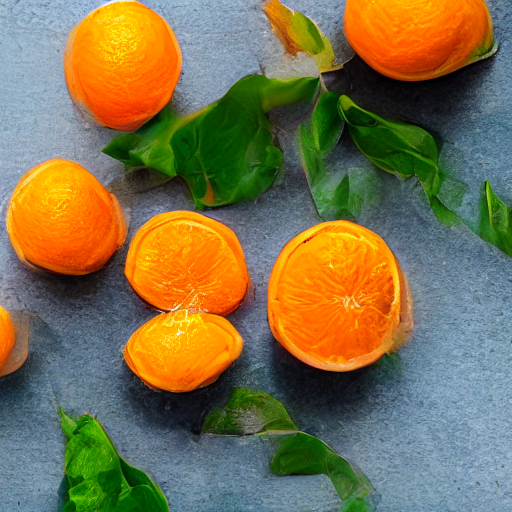

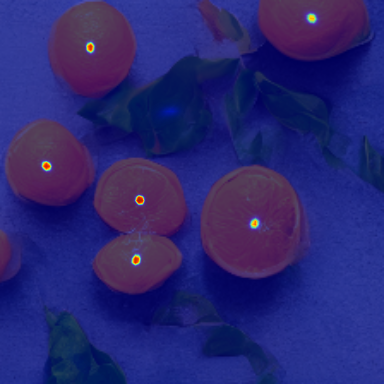

FileNotFoundError: [Errno 2] No such file or directory: 'results/oranges_1_35/actual.jpg'

In [10]:
import random


classes = ["oranges"]
intervals = [(0,5),(5,10),(10,15),(15,30),(30,50)]
scales = [90,80,70,60,60]
seeds = [35,1]

# for i in range(100):
#     clazz = random.choice(classes)
#     interval = random.choice(intervals)
#     amount = random.randint(interval[0]+1,interval[1])
#     scale = random.choice(scales)
#     seed = random.choice(seeds)
#     
#     run_experiment(amount, clazz, scale, seed)

for clazz in classes:
    for i,interval in enumerate(intervals):
        scale = scales[i]
        for amount in range(interval[0]+1,interval[1]+1):
            for seed in seeds:
                run_experiment(amount, clazz, scale, seed)

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['class', 'seed', 'amount', 'sd_count', 'sd_optimized_count'])

# Iterate over each subfolder inside the main folder
for subfolder in os.listdir("results"):
    # Construct the full path of the subfolder
    subfolder_path = os.path.join("results", subfolder)
    
    clazz, amount, seed = subfolder_path.split('_')
    detected_actual_amount = count_instances_in_image(subfolder_path+"/actual.jpg", clazz)
    detected_optimized_amount = count_instances_in_image(subfolder_path+"/optimized.jpg", clazz)

    df = df.append((clazz, seed, amount, detected_actual_amount, detected_optimized_amount), ignore_index=True)
